In [53]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

from src.data.preprocess import preprocess_series, clean_text
from src.features.vectorizer import load_vectorizer

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de evaluación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías importadas correctamente
📅 Fecha de evaluación: 2025-12-10 17:48:08


In [54]:
# Crear máscara para textos válidos
mask = (
    X_test.notna() &
    (X_test.astype(str).str.strip() != "") &
    (X_test.astype(str).str.lower() != "nan") &
    (X_test.astype(str).str.lower() != "none")
)

# Aplicar máscara
X_test_clean = X_test[mask]
y_test_clean = y_test[mask]

print("🔥 Filas originales en X_test:", len(X_test))
print("✨ Filas válidas después de limpieza:", len(X_test_clean))
print("🗑️ Filas eliminadas:", len(X_test) - len(X_test_clean))


🔥 Filas originales en X_test: 6327
✨ Filas válidas después de limpieza: 6327
🗑️ Filas eliminadas: 0


In [55]:
# Cargar dataset
df = pd.read_csv("../../data/processed/cleaned_dataset.csv")

X = df["clean_text"]
y = df["label"]

# Split (mismo que en training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cargar vectorizador y modelo
vectorizer = load_vectorizer()
model = joblib.load("../../src/models/saved/best_model.pkl")

# Vectorizar test set
X_test_vec = vectorizer.transform(X_test_clean)

# Predicciones
y_pred = model.predict(X_test_vec)

print(f"✅ Datos y modelo cargados")
print(f"📊 Test set: {len(y_test)} muestras")
print(f"🎯 Clases: {list(model.classes_)}")

>>> DEBUG: Cargando vectorizador desde: C:\Users\Linette\PycharmProjects\mental-health-monitoring\src\models\saved\tfidf_vectorizer.pkl
>>> DEBUG: Vectorizador cargado correctamente: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
>>> DEBUG: Tiene atributo idf_?: True
✅ Datos y modelo cargados
📊 Test set: 6327 muestras
🎯 Clases: ['Anxiety', 'Depression', 'Stress', 'Suicidal']


📊 MÉTRICAS GLOBALES

🎯 Accuracy:    0.7477 (74.77%)
🎯 Precision:   0.7554 (75.54%)
🎯 Recall:      0.7477 (74.77%)
🎯 F1-Score:    0.7487 (74.87%)


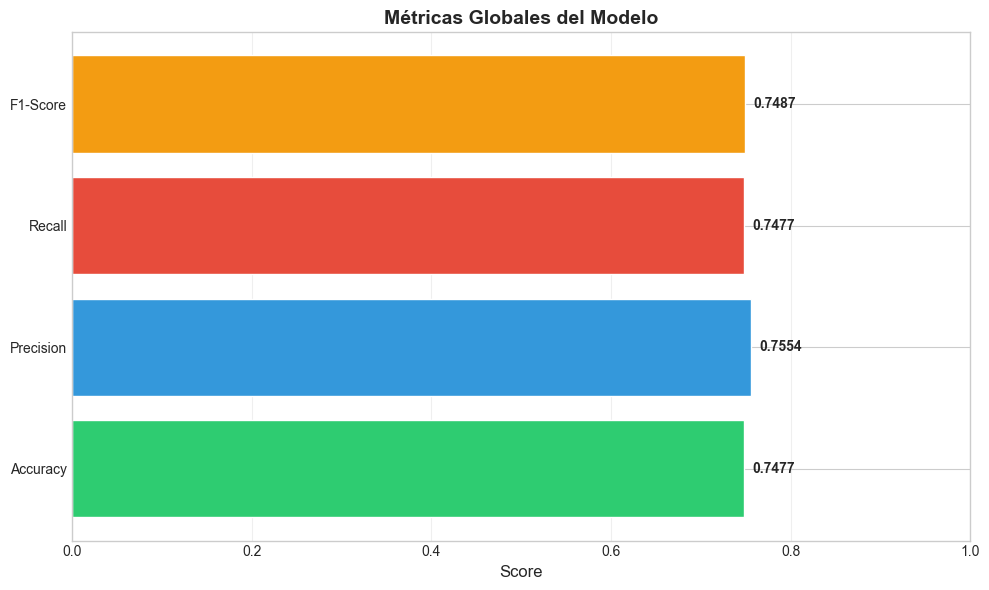

In [56]:
accuracy = accuracy_score(y_test_clean, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
      y_test_clean, y_pred, average='weighted'
)


print("="*60)
print("📊 MÉTRICAS GLOBALES")
print("="*60)
print(f"\n🎯 Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Precision:   {precision:.4f} ({precision*100:.2f}%)")
print(f"🎯 Recall:      {recall:.4f} ({recall*100:.2f}%)")
print(f"🎯 F1-Score:    {f1:.4f} ({f1*100:.2f}%)")

# Visualización
metrics_data = {
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Valor': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(metrics_df['Métrica'], metrics_df['Valor'],
               color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
ax.set_xlim([0, 1])
ax.set_xlabel('Score', fontsize=12)
ax.set_title('Métricas Globales del Modelo', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars, metrics_df['Valor'])):
    ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


📋 REPORTE DE CLASIFICACIÓN POR CLASE
              precision    recall  f1-score   support

     Anxiety       0.79      0.85      0.82       723
  Depression       0.81      0.71      0.75      3017
      Stress       0.58      0.74      0.65       459
    Suicidal       0.71      0.77      0.74      2128

    accuracy                           0.75      6327
   macro avg       0.72      0.77      0.74      6327
weighted avg       0.76      0.75      0.75      6327



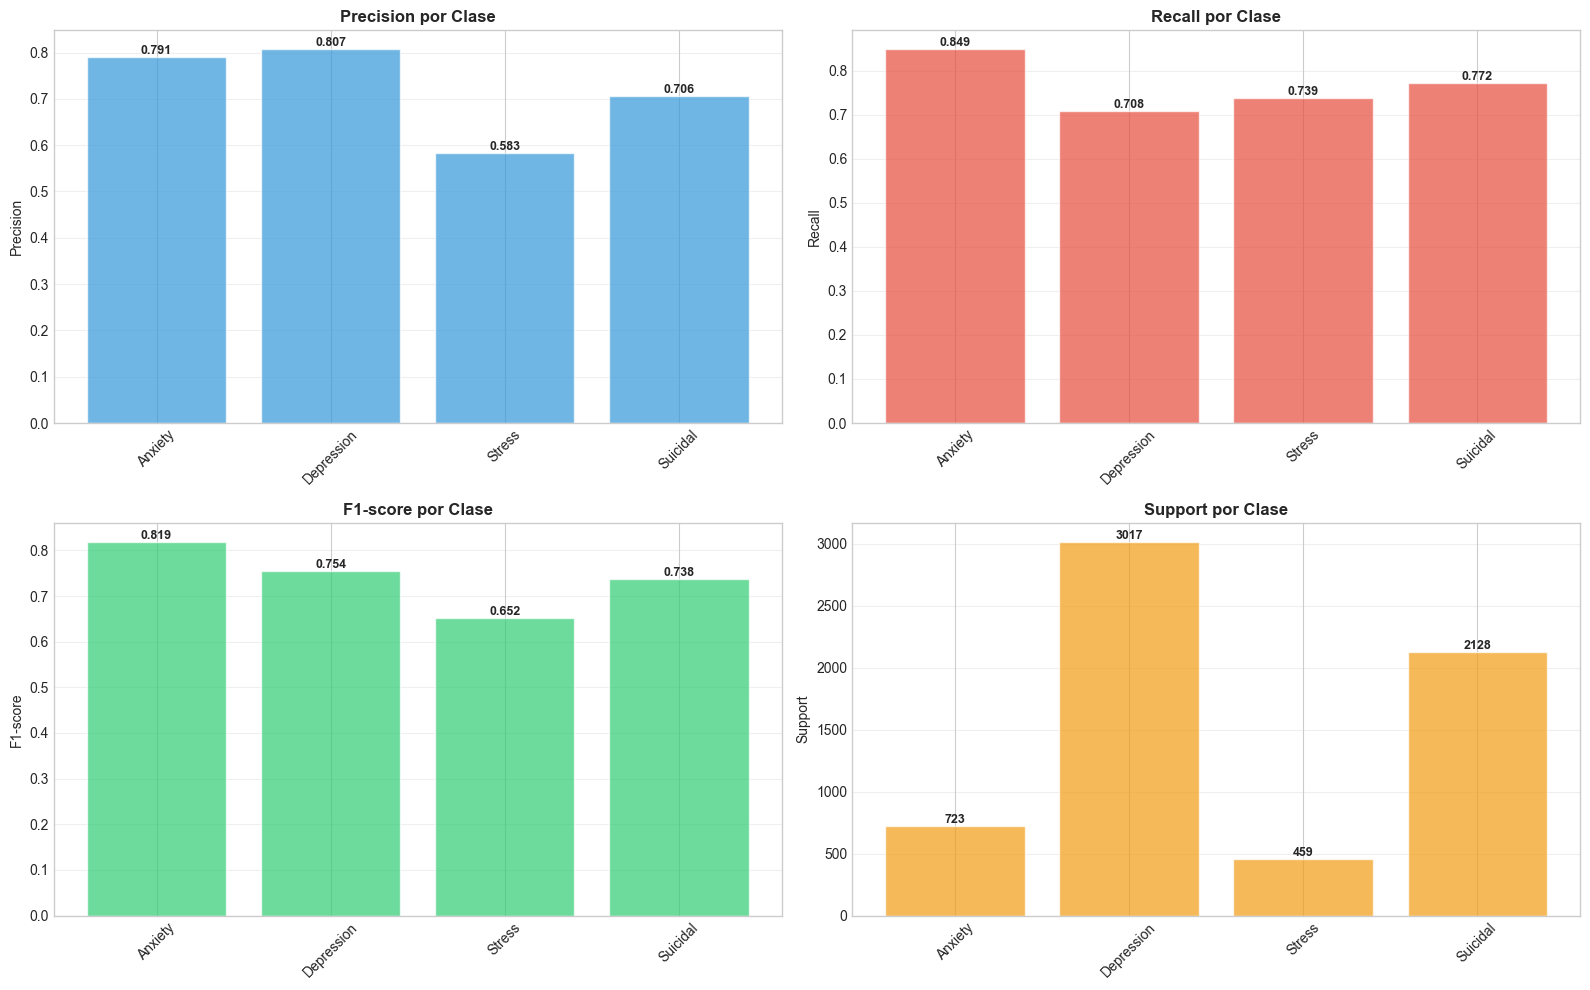

In [57]:
print("\n📋 REPORTE DE CLASIFICACIÓN POR CLASE")
print("="*60)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3]  # Excluir filas de promedio

# Visualizar métricas por clase
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics_to_plot = ['precision', 'recall', 'f1-score', 'support']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]
    values = report_df[metric].values
    classes = report_df.index

    bars = ax.bar(classes, values, color=color, alpha=0.7)
    ax.set_title(f'{metric.capitalize()} por Clase', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.capitalize(), fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}' if metric != 'support' else f'{int(value)}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


🎨 MATRIZ DE CONFUSIÓN


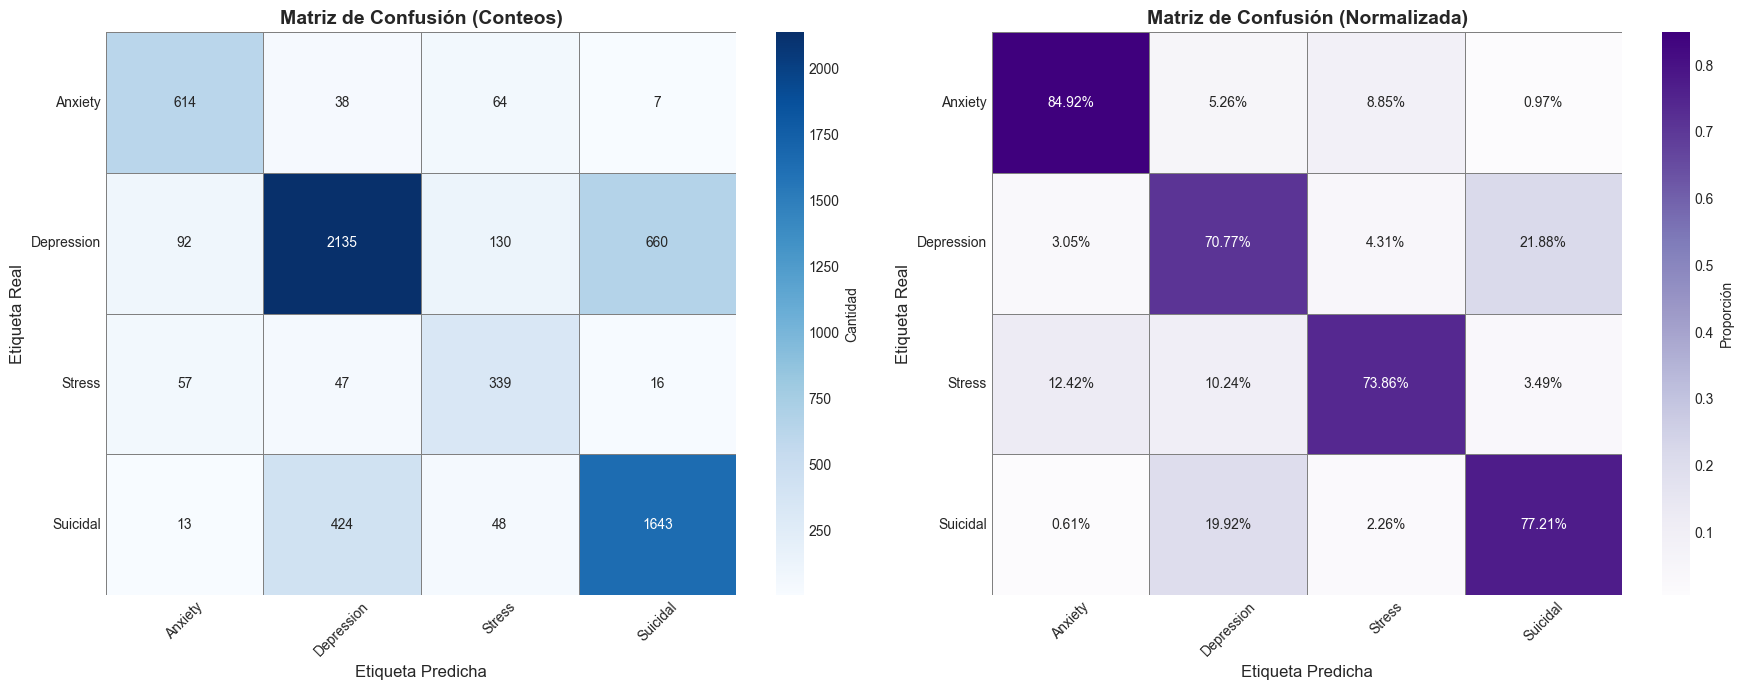


❌ ANÁLISIS DE ERRORES

Anxiety:
  Correctas:   614/723 (84.9%)
  Errores:     109/723 (15.1%)
  Confundido con:
    - Depression: 38 veces (5.3%)
    - Stress: 64 veces (8.9%)
    - Suicidal: 7 veces (1.0%)

Depression:
  Correctas:   2135/3017 (70.8%)
  Errores:     882/3017 (29.2%)
  Confundido con:
    - Anxiety: 92 veces (3.0%)
    - Stress: 130 veces (4.3%)
    - Suicidal: 660 veces (21.9%)

Stress:
  Correctas:   339/459 (73.9%)
  Errores:     120/459 (26.1%)
  Confundido con:
    - Anxiety: 57 veces (12.4%)
    - Depression: 47 veces (10.2%)
    - Suicidal: 16 veces (3.5%)

Suicidal:
  Correctas:   1643/2128 (77.2%)
  Errores:     485/2128 (22.8%)
  Confundido con:
    - Anxiety: 13 veces (0.6%)
    - Depression: 424 veces (19.9%)
    - Stress: 48 veces (2.3%)


In [58]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)
classes = model.classes_

print("\n🎨 MATRIZ DE CONFUSIÓN")
print("="*60)

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Matriz absoluta
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Cantidad'}, ax=axes[0],
            linewidths=0.5, linecolor='gray')
axes[0].set_title('Matriz de Confusión (Conteos)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Etiqueta Real', fontsize=12)
axes[0].set_xlabel('Etiqueta Predicha', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Matriz normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Purples',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Proporción'}, ax=axes[1],
            linewidths=0.5, linecolor='gray')
axes[1].set_title('Matriz de Confusión (Normalizada)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Etiqueta Real', fontsize=12)
axes[1].set_xlabel('Etiqueta Predicha', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Análisis de errores
print("\n❌ ANÁLISIS DE ERRORES")
print("="*60)
for i, true_class in enumerate(classes):
    true_positives = cm[i, i]
    total_true = cm[i, :].sum()
    errors = total_true - true_positives
    error_rate = (errors / total_true * 100) if total_true > 0 else 0

    print(f"\n{true_class}:")
    print(f"  Correctas:   {true_positives}/{total_true} ({(true_positives/total_true*100):.1f}%)")
    print(f"  Errores:     {errors}/{total_true} ({error_rate:.1f}%)")

    if errors > 0:
        print(f"  Confundido con:")
        for j, pred_class in enumerate(classes):
            if i != j and cm[i, j] > 0:
                print(f"    - {pred_class}: {cm[i, j]} veces ({cm[i, j]/total_true*100:.1f}%)")


📈 CURVAS ROC (One-vs-Rest)


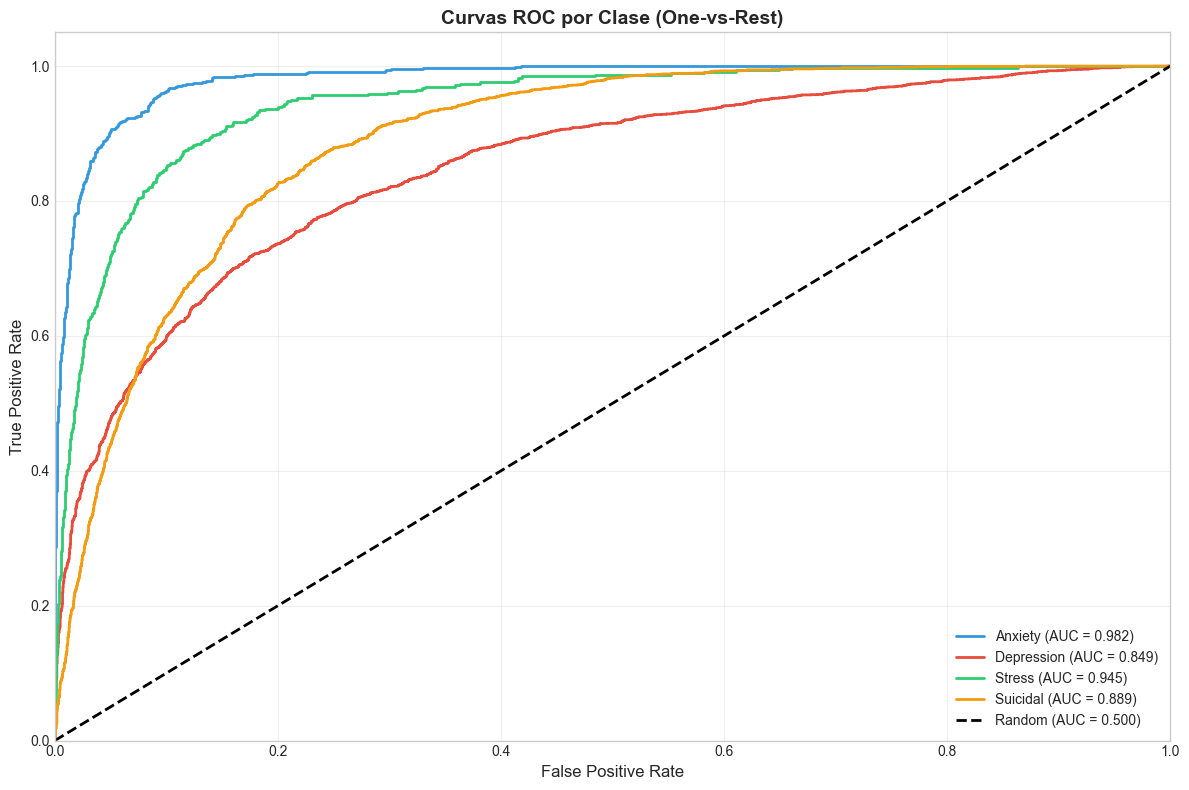


AUC Scores por clase:
  Anxiety             : 0.9815
  Depression          : 0.8492
  Stress              : 0.9445
  Suicidal            : 0.8894

  Media (Macro-average): 0.9162


In [59]:
print("\n📈 CURVAS ROC (One-vs-Rest)")
print("="*60)

# Binarizar las etiquetas
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Obtener scores de decisión
y_score = model.decision_function(X_test_vec)

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualizar
plt.figure(figsize=(12, 8))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC por Clase (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Imprimir AUC scores
print("\nAUC Scores por clase:")
for i, class_name in enumerate(classes):
    print(f"  {class_name:20s}: {roc_auc[i]:.4f}")

mean_auc = np.mean(list(roc_auc.values()))
print(f"\n  Media (Macro-average): {mean_auc:.4f}")

In [60]:
print("\n🔍 ANÁLISIS DE EJEMPLOS")
print("="*60)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'text': X_test.values,
    'true_label': y_test.values,
    'predicted_label': y_pred,
    'correct': y_test.values == y_pred
})

correct_preds = results_df[results_df['correct'] == True]
incorrect_preds = results_df[results_df['correct'] == False]

print(f"\n✅ Predicciones correctas: {len(correct_preds)} ({len(correct_preds)/len(results_df)*100:.1f}%)")
print(f"❌ Predicciones incorrectas: {len(incorrect_preds)} ({len(incorrect_preds)/len(results_df)*100:.1f}%)")

# Ejemplos correctos
print("\n" + "="*60)
print("✅ EJEMPLOS DE PREDICCIONES CORRECTAS (2 por clase)")
print("="*60)

for class_name in classes:
    class_correct = correct_preds[correct_preds['true_label'] == class_name]
    if len(class_correct) > 0:
        print(f"\n🏷️ {class_name}:")
        for idx, row in class_correct.head(2).iterrows():
            text_preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
            print(f"  • {text_preview}")
            print(f"    ✓ Predicción: {row['predicted_label']}\n")


🔍 ANÁLISIS DE EJEMPLOS

✅ Predicciones correctas: 4731 (74.8%)
❌ Predicciones incorrectas: 1596 (25.2%)

✅ EJEMPLOS DE PREDICCIONES CORRECTAS (2 por clase)

🏷️ Anxiety:
  • head pulsing medicine side effect suffering started doctor prescribed clonazepam gabapentin took wee...
    ✓ Predicción: Anxiety

  • anxiety cause spot almost constantly itch chin around mouth lip facial hair even feel prickly seems ...
    ✓ Predicción: Anxiety


🏷️ Depression:
  • f attempted take life five day ago wa second serious attempt took couple pill alchohol walked ledge ...
    ✓ Predicción: Depression

  • sad lonely anyone talk know tried reaching people feel desperate alone make feel even worse prof one...
    ✓ Predicción: Depression


🏷️ Stress:
  • heart rate stress yeah basically cant go doctor yet thing keep happening heart beating fast andor ha...
    ✓ Predicción: Stress

  • hardly job maybe even next town place age could find job car reliable car place stay get foot transp...
    ✓ Predicci

In [61]:
# Ejemplos incorrectos
print("\n" + "="*60)
print("❌ EJEMPLOS DE PREDICCIONES INCORRECTAS (5 casos)")
print("="*60)

if len(incorrect_preds) > 0:
    for idx, row in incorrect_preds.head(5).iterrows():
        text_preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
        print(f"\nTexto: {text_preview}")
        print(f"  Real:      {row['true_label']}")
        print(f"  Predicho:  {row['predicted_label']} ❌")
        print("-" * 60)
else:
    print("\n¡Excelente! No hay predicciones incorrectas.")


❌ EJEMPLOS DE PREDICCIONES INCORRECTAS (5 casos)

Texto: feel chained ground submerged mud wish get better nothing world would rather sleeping cannot move ba...
  Real:      Depression
  Predicho:  Suicidal ❌
------------------------------------------------------------

Texto: dealing nonstop selfhatred obsessively ruminating every bad thing ever done point energy motivation ...
  Real:      Suicidal
  Predicho:  Depression ❌
------------------------------------------------------------

Texto: feel ugly talk anyone make friend date really hurt isolated horrible cannot think otherwise ugly tal...
  Real:      Depression
  Predicho:  Suicidal ❌
------------------------------------------------------------

Texto: idk tell someone quit talk please advice would really really helpful
  Real:      Stress
  Predicho:  Depression ❌
------------------------------------------------------------

Texto: two friend attempt longer friend one narcissist abusive borderline attempt traumatized made ups

In [62]:
print("\n🧪 PRUEBAS CON EJEMPLOS MANUALES")
print("="*60)

# Ejemplos de prueba
test_examples = [
    "Me siento muy ansioso, no puedo dormir por las noches",
    "Estoy tan feliz hoy, todo está saliendo bien",
    "No veo sentido a nada, me siento vacío",
    "Tengo mucho estrés por el trabajo, demasiadas cosas que hacer",
    "I feel extremely anxious and worried all the time",
    "Life feels meaningless and I don't want to continue",
    "Just a normal day, nothing special",
    "Work pressure is killing me, so much stress"
]

print("\nProbando ejemplos...\n")

for i, text in enumerate(test_examples, 1):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]

    # Confianza
    decision_values = model.decision_function(vec)[0]
    exp_values = np.exp(decision_values - np.max(decision_values))
    probs = exp_values / exp_values.sum()
    confidence = max(probs) * 100

    print(f"{i}. Texto: \"{text}\"")
    print(f"   → Predicción: {pred} (Confianza: {confidence:.1f}%)\n")


🧪 PRUEBAS CON EJEMPLOS MANUALES

Probando ejemplos...

1. Texto: "Me siento muy ansioso, no puedo dormir por las noches"
   → Predicción: Depression (Confianza: 31.4%)

2. Texto: "Estoy tan feliz hoy, todo está saliendo bien"
   → Predicción: Stress (Confianza: 27.5%)

3. Texto: "No veo sentido a nada, me siento vacío"
   → Predicción: Stress (Confianza: 27.6%)

4. Texto: "Tengo mucho estrés por el trabajo, demasiadas cosas que hacer"
   → Predicción: Suicidal (Confianza: 31.8%)

5. Texto: "I feel extremely anxious and worried all the time"
   → Predicción: Anxiety (Confianza: 78.0%)

6. Texto: "Life feels meaningless and I don't want to continue"
   → Predicción: Depression (Confianza: 31.4%)

7. Texto: "Just a normal day, nothing special"
   → Predicción: Depression (Confianza: 37.9%)

8. Texto: "Work pressure is killing me, so much stress"
   → Predicción: Stress (Confianza: 75.7%)



In [63]:
import os

# Crear directorio
os.makedirs("../../reports", exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = f"../reports/evaluation_report_{timestamp}.txt"

# Escribir reporte
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write(" REPORTE DE EVALUACIÓN - SISTEMA DE MONITOREO DE SALUD MENTAL\n")
    f.write("="*70 + "\n\n")

    f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Modelo: LinearSVC (Support Vector Machine)\n")
    f.write(f"Dataset: {len(df)} muestras totales\n")
    f.write(f"Test Set: {len(y_test)} muestras\n\n")

    f.write("="*70 + "\n")
    f.write("MÉTRICAS GLOBALES\n")
    f.write("="*70 + "\n")
    f.write(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"Precision: {precision:.4f} ({precision*100:.2f}%)\n")
    f.write(f"Recall:    {recall:.4f} ({recall*100:.2f}%)\n")
    f.write(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)\n\n")

    f.write("="*70 + "\n")
    f.write("REPORTE DETALLADO POR CLASE\n")
    f.write("="*70 + "\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\n")

    f.write("="*70 + "\n")
    f.write("MATRIZ DE CONFUSIÓN\n")
    f.write("="*70 + "\n")
    f.write(f"\nClases: {list(classes)}\n\n")
    f.write(pd.DataFrame(cm, index=classes, columns=classes).to_string())
    f.write("\n\n")

    f.write("="*70 + "\n")
    f.write("AUC SCORES (One-vs-Rest)\n")
    f.write("="*70 + "\n")
    for i, class_name in enumerate(classes):
        f.write(f"{class_name:20s}: {roc_auc[i]:.4f}\n")
    f.write(f"\nMedia (Macro-average): {mean_auc:.4f}\n")

print(f"✅ Reporte guardado en: {report_path}")

# Guardar predicciones en CSV
results_csv_path = f"../reports/predictions_{timestamp}.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"✅ Predicciones guardadas en: {results_csv_path}")

# Guardar matriz de confusión
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_path = f"../reports/confusion_matrix_{timestamp}.csv"
cm_df.to_csv(cm_path)
print(f"✅ Matriz de confusión guardada en: {cm_path}")

print("\n🎉 Evaluación completada exitosamente!")

✅ Reporte guardado en: ../reports/evaluation_report_20251210_174905.txt
✅ Predicciones guardadas en: ../reports/predictions_20251210_174905.csv
✅ Matriz de confusión guardada en: ../reports/confusion_matrix_20251210_174905.csv

🎉 Evaluación completada exitosamente!
